# Entirely classical transfer learning (*ants* / *bees*)

In this notebook we present a fully classical version for our quantum transfer learning example of Ref. [1].
Instead of replacing the last layer of the residual network ResNet18 [3] with dressed quantum circuit,
in this case we replace it with a classical layer (or network) which maps the 512 output features of the pre-trained network to 2 output nodes, associated to the labels "ants" and "bees".

Up to the choice of the hyperparameters, this is the same approach of this PyTorch  [tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by Sasank Chilamkurthy [2].



## General setup
**Important:** this code makes use of the machine learning framework *PyTorch*, which is assumed to be correctly installed.

The main imported packages are: some common PyTorch libraries and the python plotting library `matplotlib`.

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Numpy
import numpy as np

# Other tools
import time
import os
import copy

env: OMP_NUM_THREADS=1


Setting of the main parameters of the network model and of the training process.<br>

In [2]:
classical_model = '512_2'        # Possible choices: '512_2','512_4_2','551_512_2'. 
step = 0.0004                    # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 30                  # Number of training epochs
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Dataset loading

**Important:** The dataset containing images of *ants* and *bees* can be downloaded [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and should be extracted in the subfolder `../data/hymenoptera_data`. 

The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

In [4]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

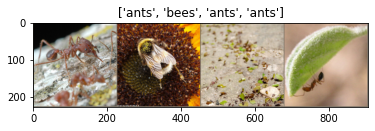

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the dataloaders.

In [6]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

## Classical transfer learning model (classical-to-classical).


We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer learning* approach:
1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo.<br> **Important:** the model is downloaded from Internet and it may take a long time (only the first time). 
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with a trainable classical network.

In [7]:
model_classical = torchvision.models.resnet18(pretrained=True)

for param in model_classical.parameters():
    param.requires_grad = False
    
if  classical_model == '512_2':
    model_classical.fc = nn.Linear(512, 2)
    
elif classical_model == '512_4_2':
    model_classical.fc = nn.Sequential(nn.Linear(512, 4), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '551_512_2':
    model_classical.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# Use CUDA or CPU according to the "device" object.
model_classical = model_classical.to(device)

## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

In [8]:
criterion = nn.CrossEntropyLoss()

We also initialize the *Adam optimizer* which is called at each training step in order to update the weights of the model.

In [9]:
optimizer_hybrid = optim.Adam(model_classical.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every 10 epochs.

In [10]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications). 

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        
        for epoch in range(num_epochs):    
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    model.train()  
                else:
                    # Set model to evaluate mode
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Update learning rate
                if phase == 'train':
                    scheduler.step()
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results           
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

We are ready to perform the actual training process.

In [12]:
model_hybrid = train_model(model_classical, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/30 Loss: 0.6640 Acc: 0.5574        
Phase: val   Epoch: 1/30 Loss: 0.5196 Acc: 0.7647        
Phase: train Epoch: 2/30 Loss: 0.4964 Acc: 0.7992        
Phase: val   Epoch: 2/30 Loss: 0.3941 Acc: 0.8693        
Phase: train Epoch: 3/30 Loss: 0.5183 Acc: 0.7254        
Phase: val   Epoch: 3/30 Loss: 0.3306 Acc: 0.9150        
Phase: train Epoch: 4/30 Loss: 0.4213 Acc: 0.8197        
Phase: val   Epoch: 4/30 Loss: 0.3166 Acc: 0.8758        
Phase: train Epoch: 5/30 Loss: 0.4053 Acc: 0.8238        
Phase: val   Epoch: 5/30 Loss: 0.2645 Acc: 0.9216        
Phase: train Epoch: 6/30 Loss: 0.4178 Acc: 0.8074        
Phase: val   Epoch: 6/30 Loss: 0.2455 Acc: 0.9412        
Phase: train Epoch: 7/30 Loss: 0.3883 Acc: 0.8197        
Phase: val   Epoch: 7/30 Loss: 0.2378 Acc: 0.9216        
Phase: train Epoch: 8/30 Loss: 0.3340 Acc: 0.8648        
Phase: val   Epoch: 8/30 Loss: 0.2221 Acc: 0.9346        
Phase: train Epoch: 9/30 Loss: 0.2984 Acc: 0.8648     

We save the optimal weights that achieved the best accuracy into a PyTorch file that will be created in the current working directory. In this way, the saved weights can be loaded in the future without training again.

**Important: Be aware that running next cell will overwrite a previously saved file. So, we suggest to run the next cell only after a good training process.**

In [13]:
torch.save(model_classical.state_dict(), "classical_ants_bees.pt")
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file
To load the pre-trained weights it is necessary to first define the model. So, before this cell, one should have run all the cells before the [Training and results](##Training_and_results) section. 

In [14]:
model_classical.load_state_dict(torch.load("classical_ants_bees.pt"))

<All keys matched successfully>

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [15]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

# Testing loop
for inputs, labels in dataloaders['val']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_classical(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 39/39
Test Loss: 0.1981 Test Acc: 0.9542        


## Visualize the model
Let us compute and the visualize the predictions for a batch of test data.
*Hint:* re-run the next cell to see more samples.

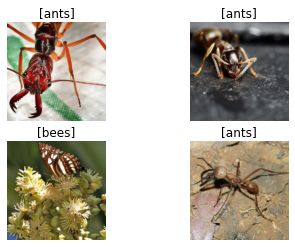

In [16]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_classical, num_images=batch_size)

## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).